In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bikeGraphOverall = nx.DiGraph()
df = pd.read_csv("LondonBikeJourneyAug2023.csv")
ride_counts = df.groupby(['Start station', 'End station']).size().reset_index(name='ride_count')
for _, row in ride_counts.iterrows():
        bikeGraphOverall.add_edge(row['Start station'], row['End station'], weight=row['ride_count'])

Total number of stations: 802
Total number of routes: 191630


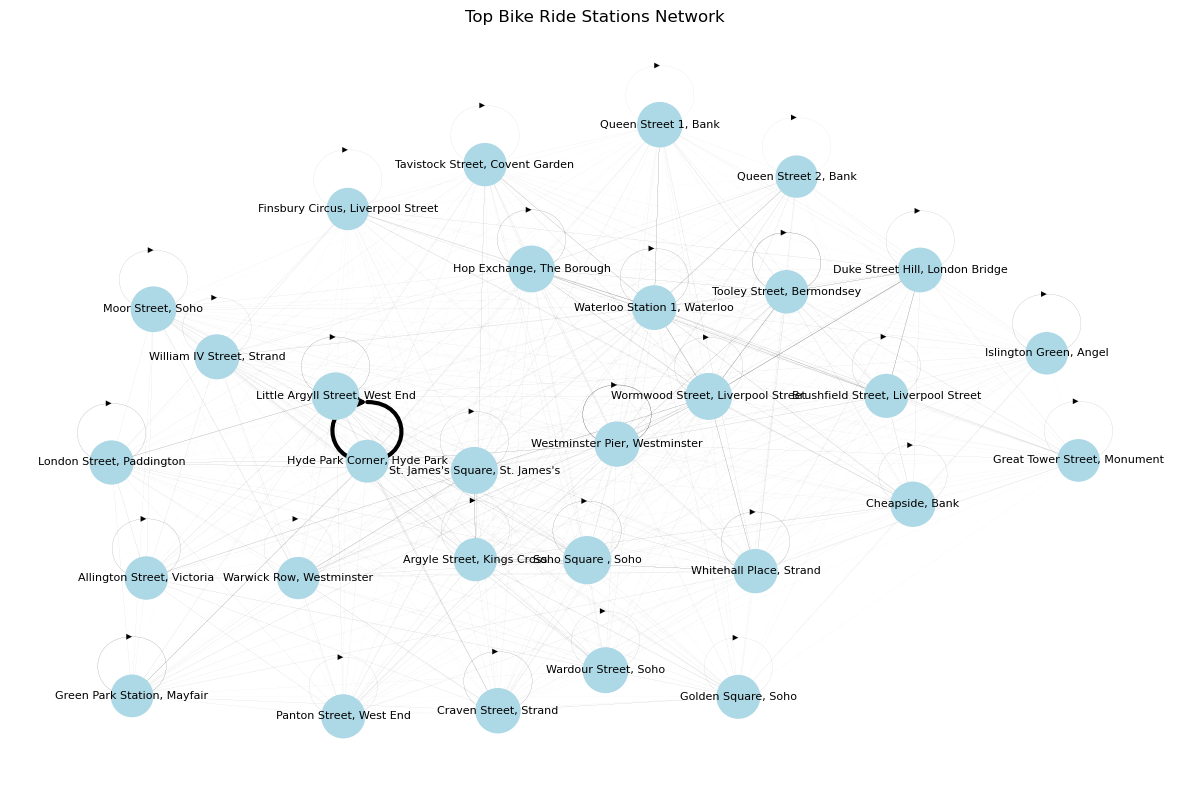


Top 10 Most Frequent Routes:
Hyde Park Corner, Hyde Park → Hyde Park Corner, Hyde Park: 2966 rides
Podium, Queen Elizabeth Olympic Park → Podium, Queen Elizabeth Olympic Park: 1813 rides
Triangle Car Park, Hyde Park → Triangle Car Park, Hyde Park: 1391 rides
Black Lion Gate, Kensington Gardens → Black Lion Gate, Kensington Gardens: 1343 rides
Albert Gate, Hyde Park → Albert Gate, Hyde Park: 1227 rides
Park Lane , Hyde Park → Park Lane , Hyde Park: 998 rides
Palace Gate, Kensington Gardens → Palace Gate, Kensington Gardens: 571 rides
Queen's Gate, Kensington Gardens → Queen's Gate, Kensington Gardens: 520 rides
Timber Lodge, Queen Elizabeth Olympic Park → Timber Lodge, Queen Elizabeth Olympic Park: 488 rides
Hyde Park Corner, Hyde Park → Albert Gate, Hyde Park: 464 rides


In [15]:
def visualize_graph(G, top_n=30):
    station_degrees = dict(G.degree())
    top_stations = sorted(station_degrees, key=station_degrees.get, reverse=True)[:top_n]
    
    subgraph = G.subgraph(top_stations)
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
    
    nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', 
                            node_size=[station_degrees[node] for node in subgraph.nodes()])
    
    edges = subgraph.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    nx.draw_networkx_edges(subgraph, pos, width=[w/1000 for w in weights], 
                            edge_color='black', arrows=True)
    
    nx.draw_networkx_labels(subgraph, pos, font_size=8)
    
    plt.title('Top Bike Ride Stations Network')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


print(f"Total number of stations: {len(bikeGraphOverall.nodes())}")
print(f"Total number of routes: {len(bikeGraphOverall.edges())}")

visualize_graph(bikeGraphOverall)

route_frequencies = [(u, v, d['weight']) for (u, v, d) in bikeGraphOverall.edges(data=True)]
top_routes = sorted(route_frequencies, key=lambda x: x[2], reverse=True)[:10]
print("\nTop 10 Most Frequent Routes:")
for start, end, count in top_routes:
    print(f"{start} → {end}: {count} rides")

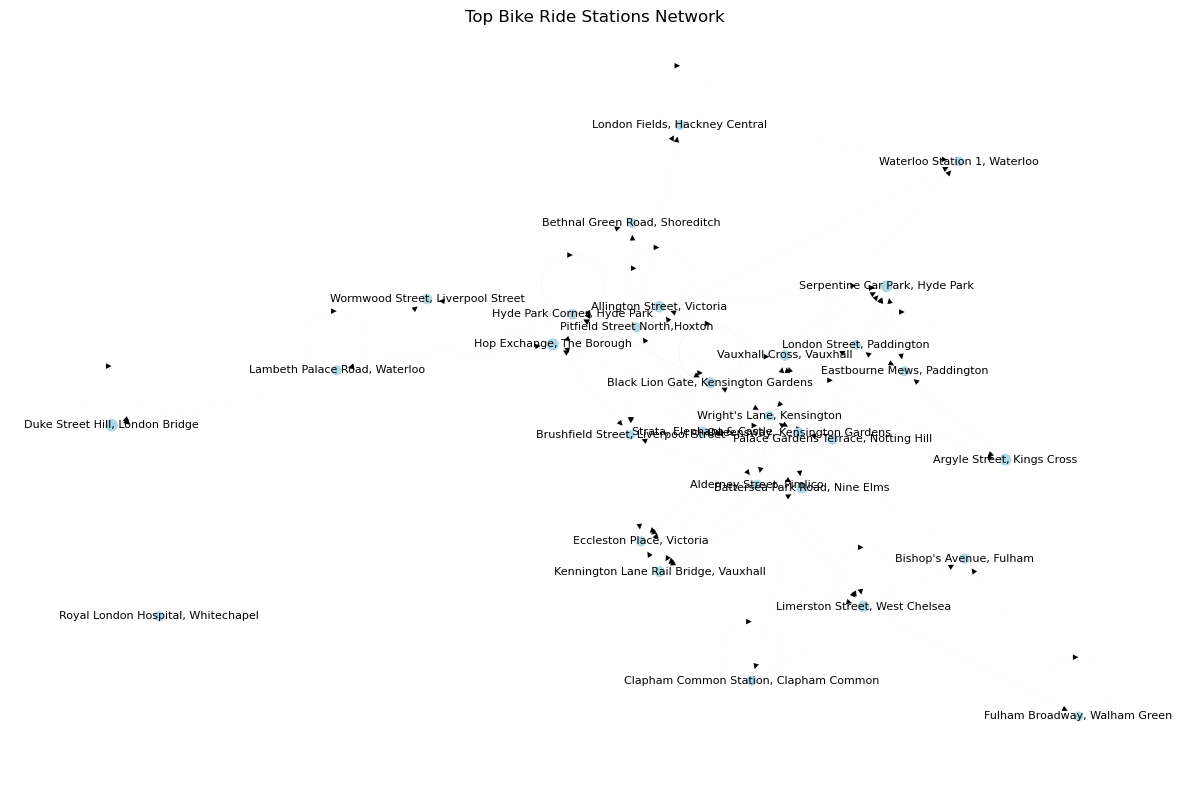

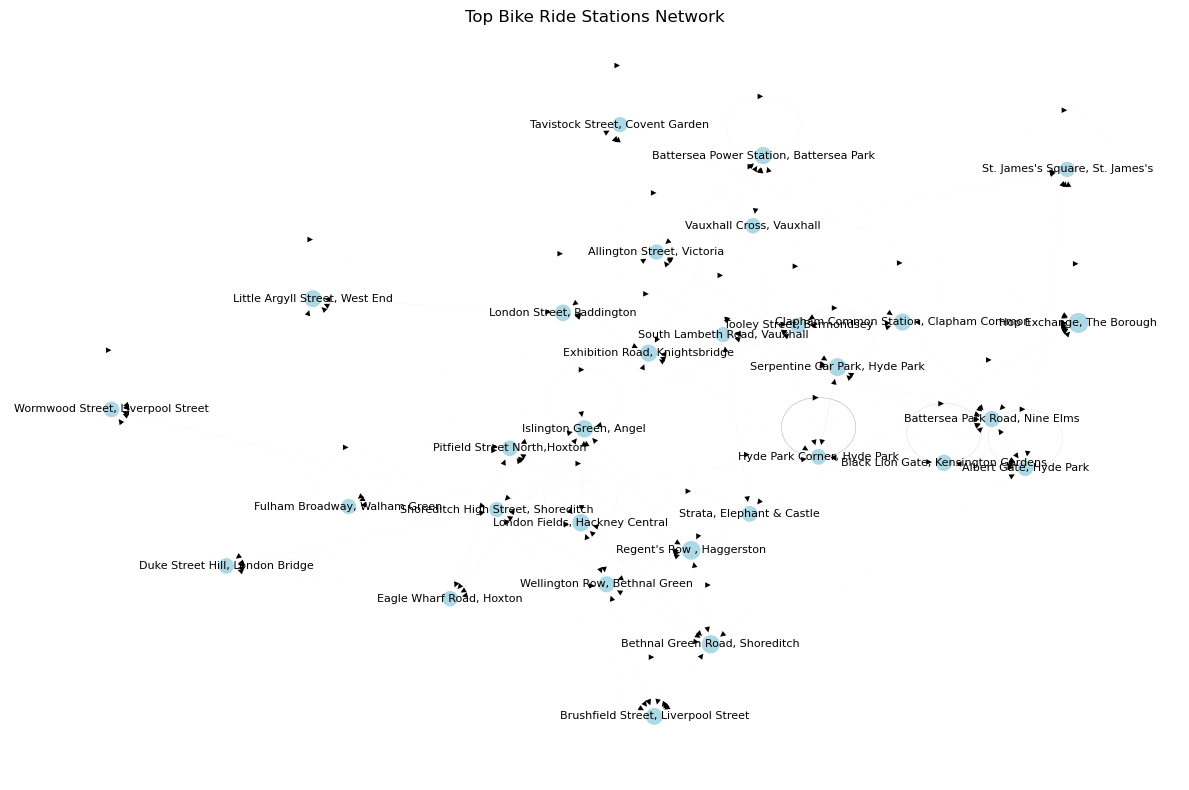

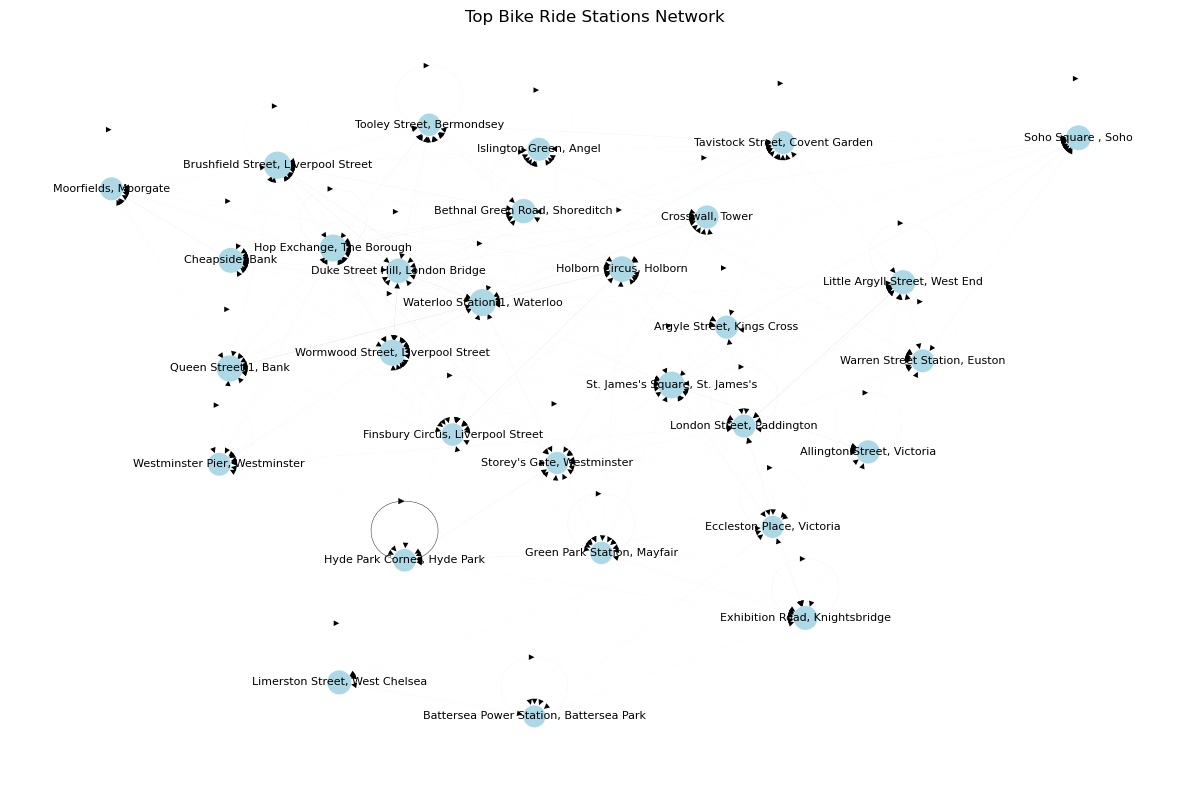

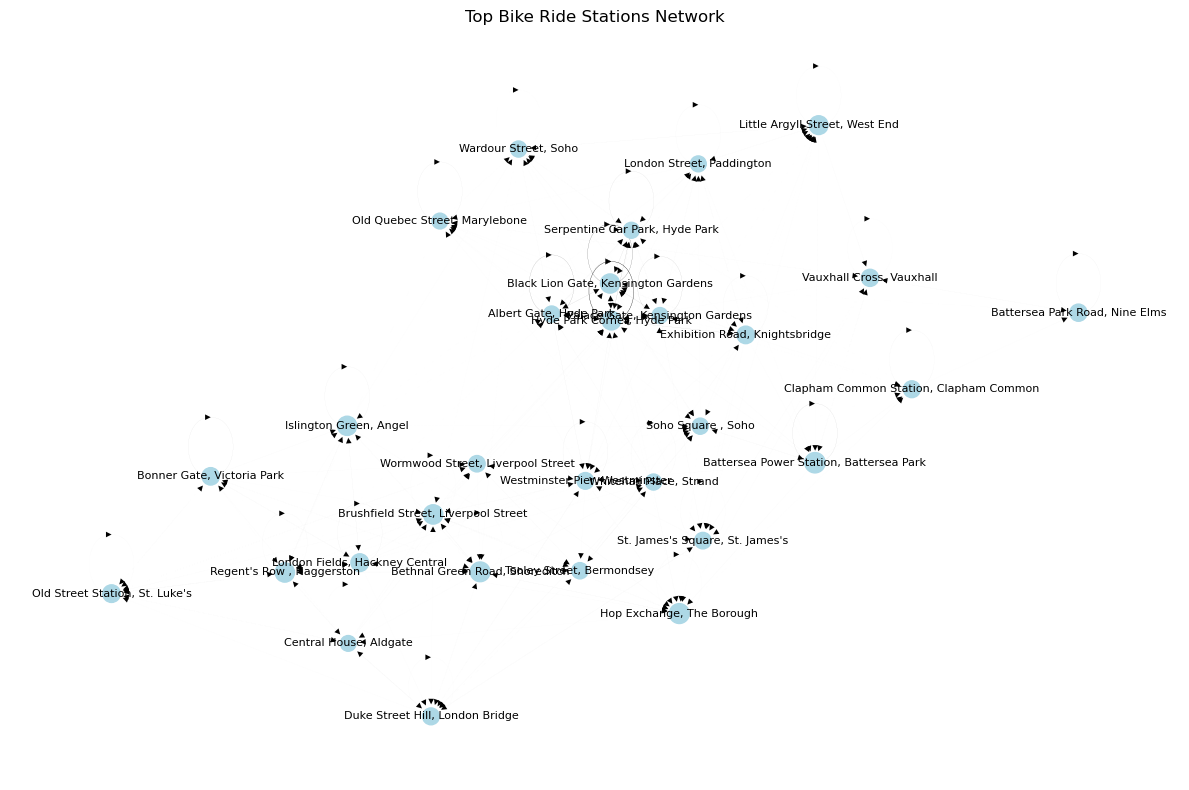

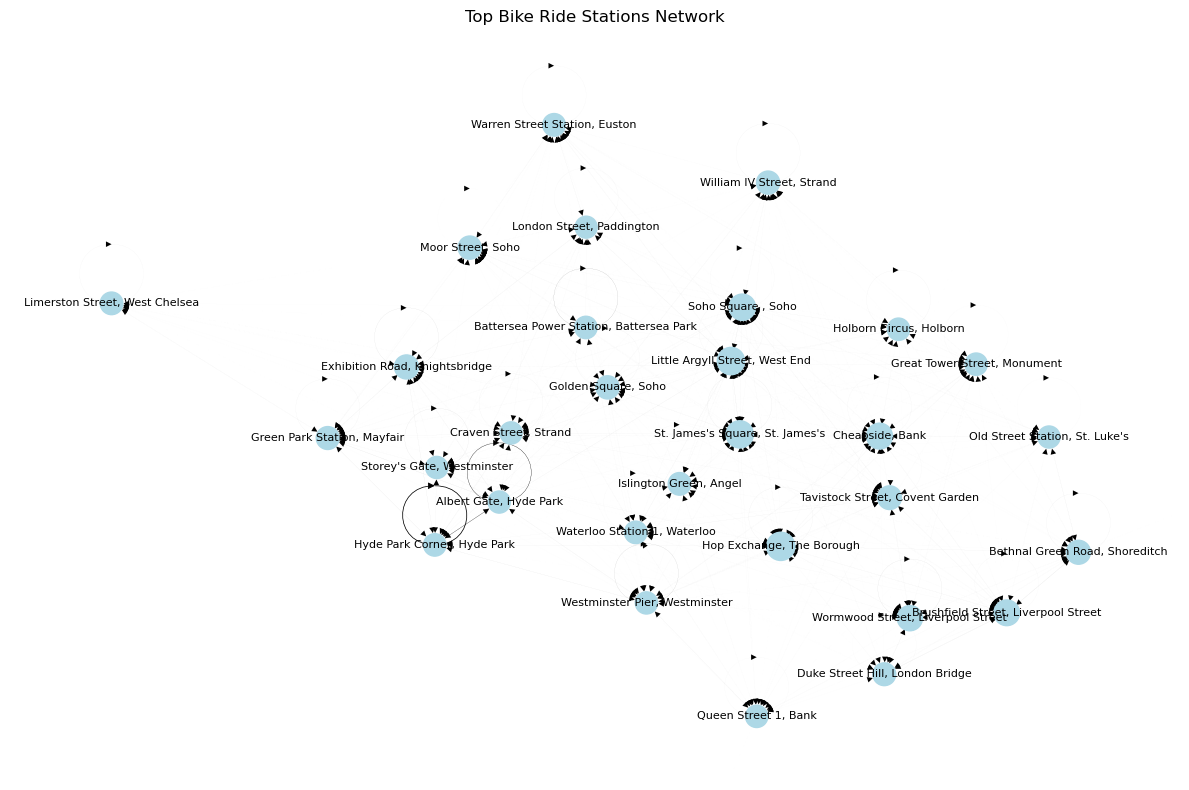

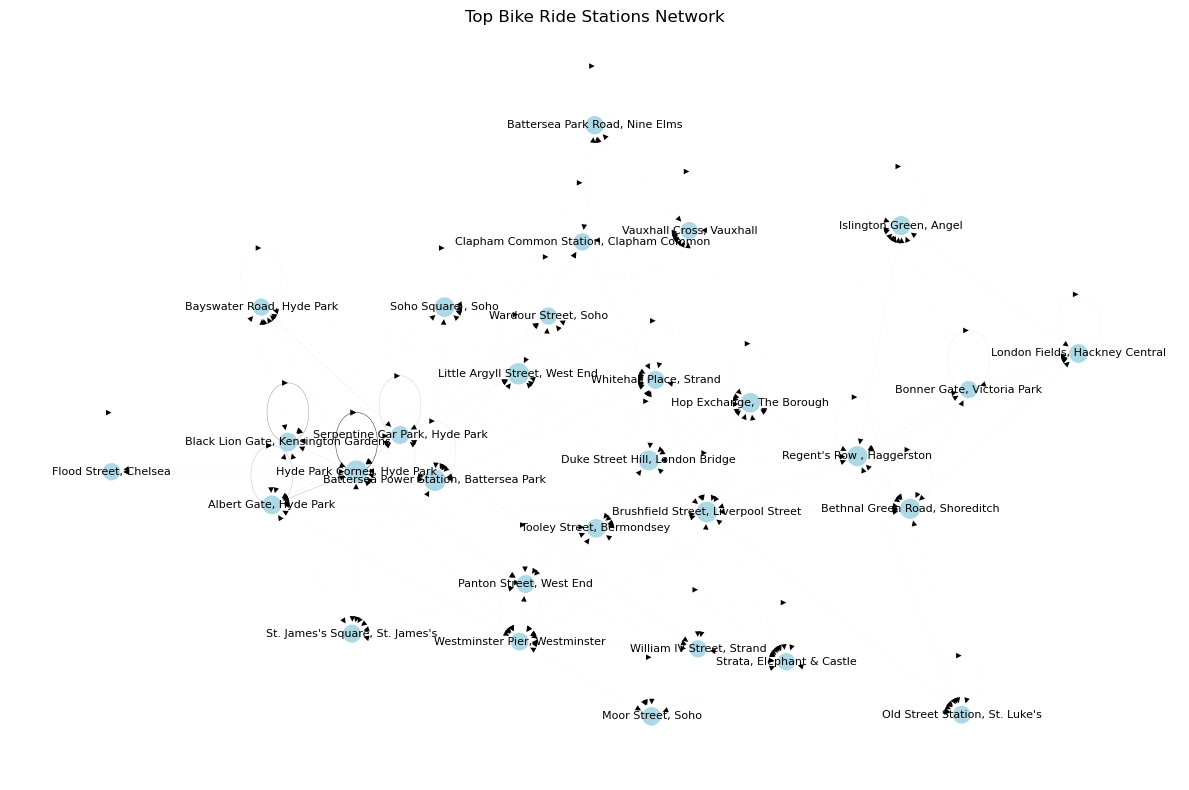

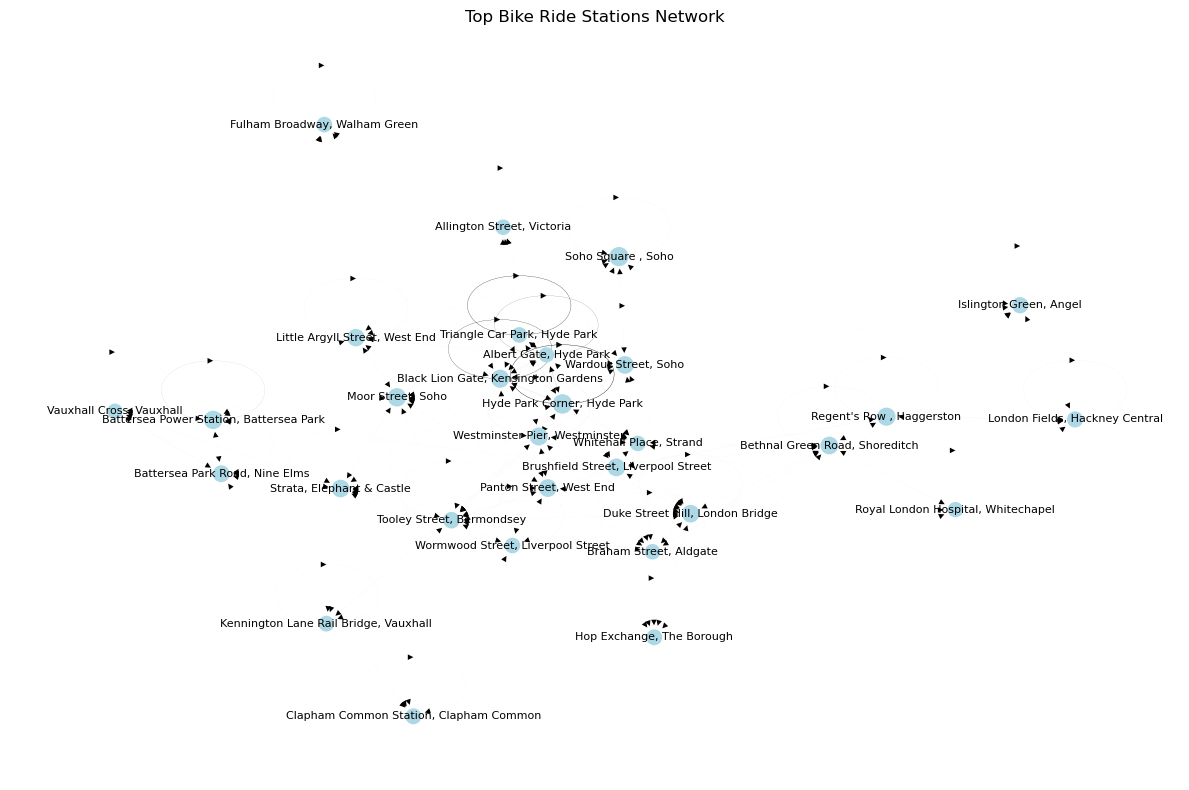

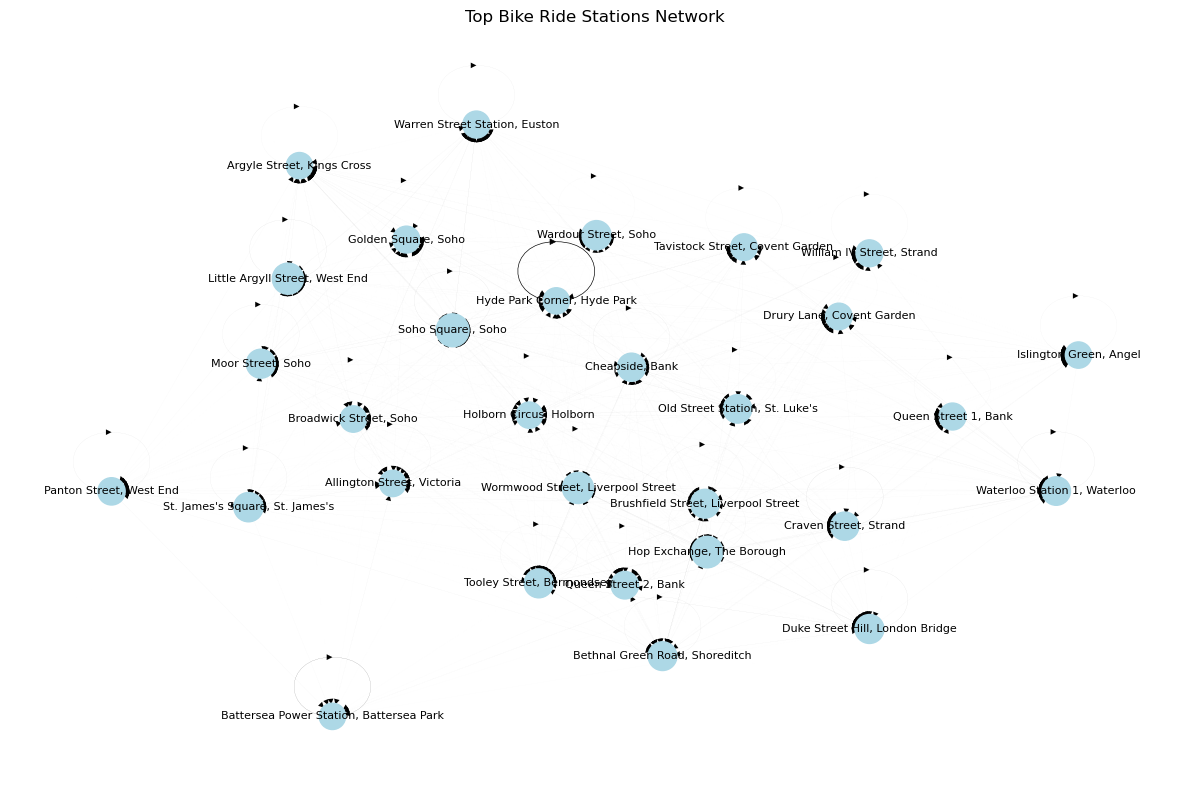

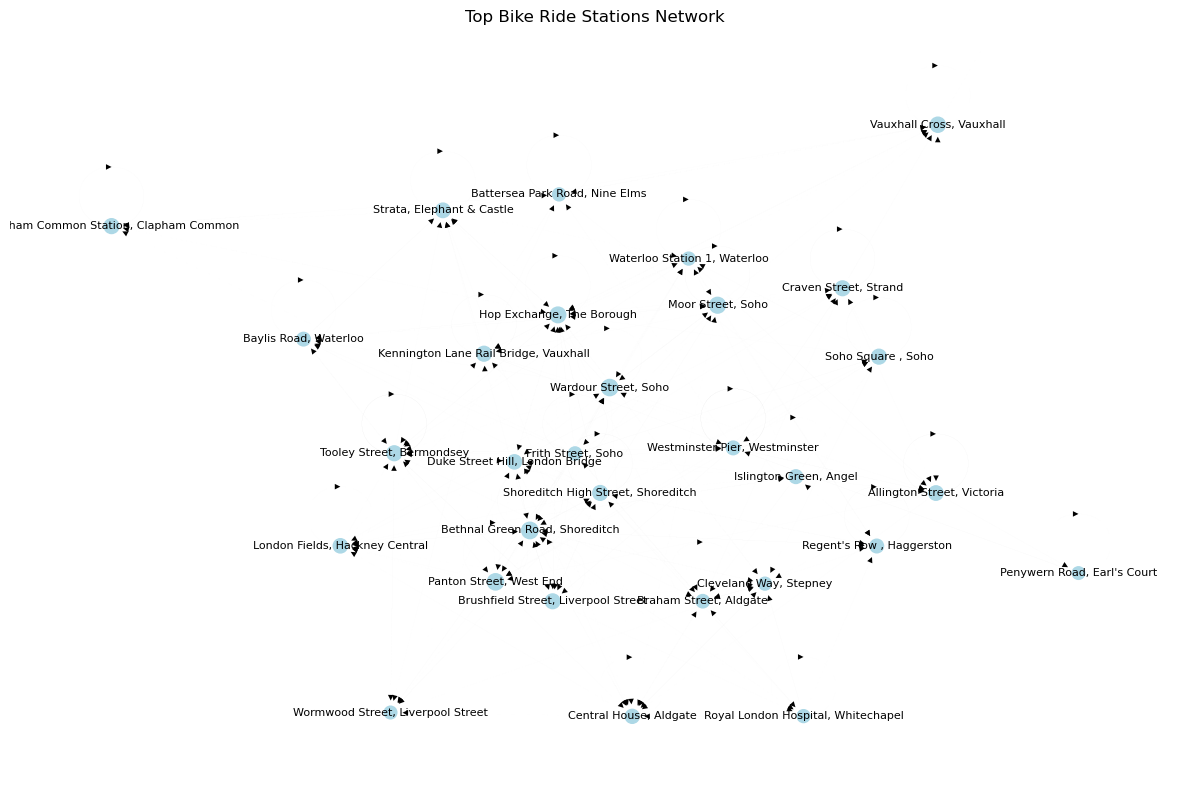

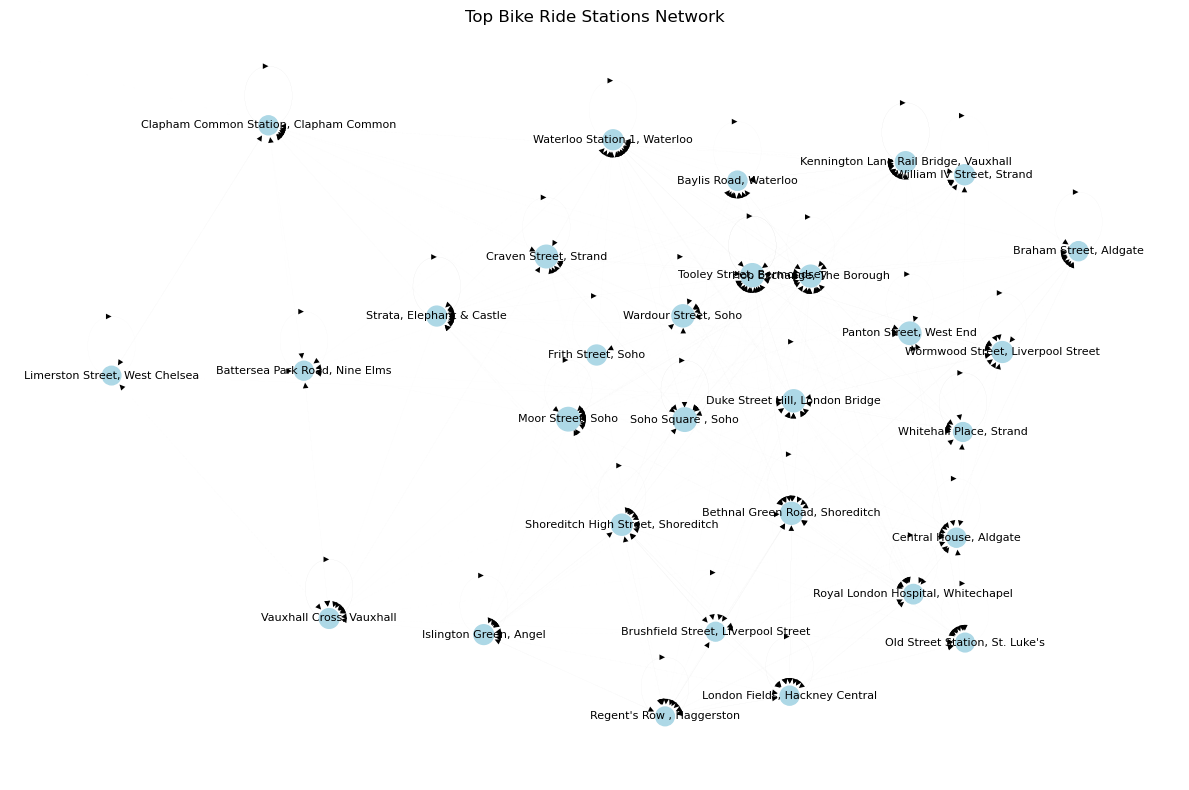

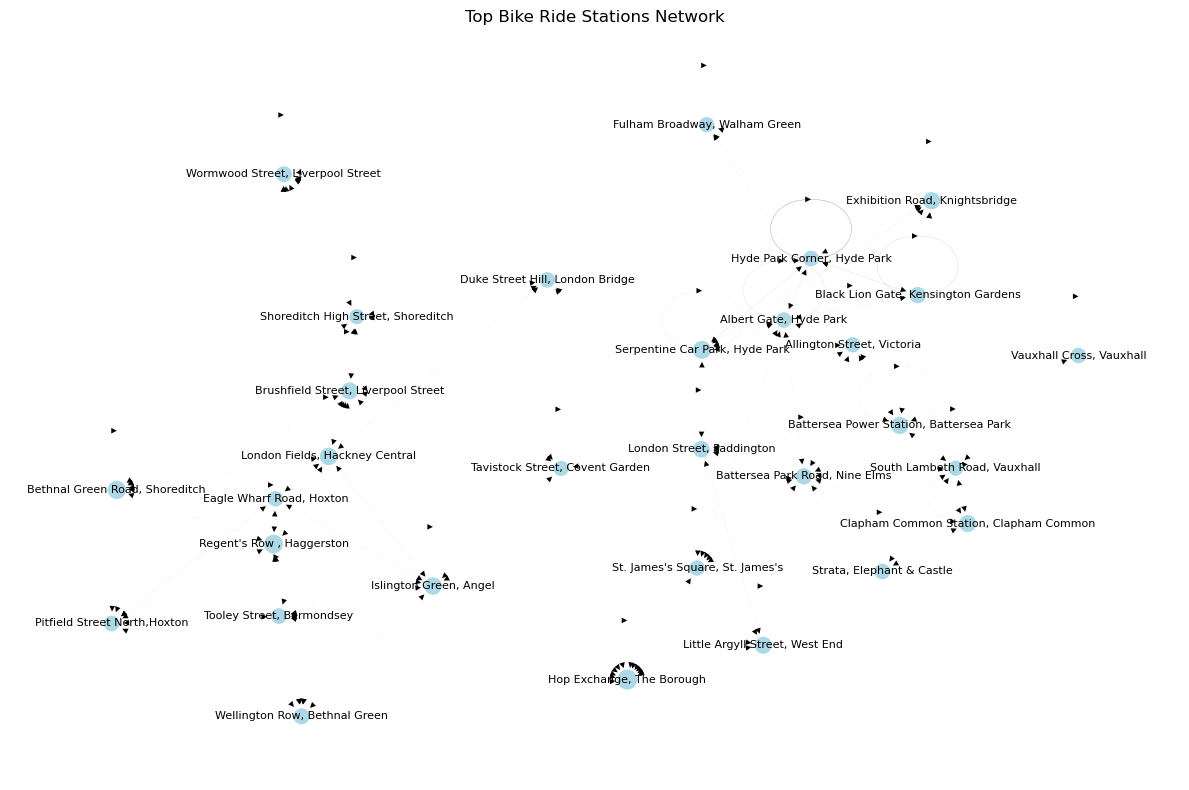


Weekend - Morning Peak Analysis:
Total Stations: 799
Total Routes: 18149

Station Removal Impact:

Random Removal:
remaining_stations: 640
remaining_routes: 11744
connectivity_reduction: 0.35291200617113894

High Centrality Removal:
remaining_stations: 640
remaining_routes: 7378
connectivity_reduction: 0.5934762245853766



Weekday - Morning Peak Analysis:
Total Stations: 801
Total Routes: 41957

Station Removal Impact:

Random Removal:
remaining_stations: 641
remaining_routes: 26614
connectivity_reduction: 0.3656839144838764

High Centrality Removal:
remaining_stations: 641
remaining_routes: 17558
connectivity_reduction: 0.5815239411778725


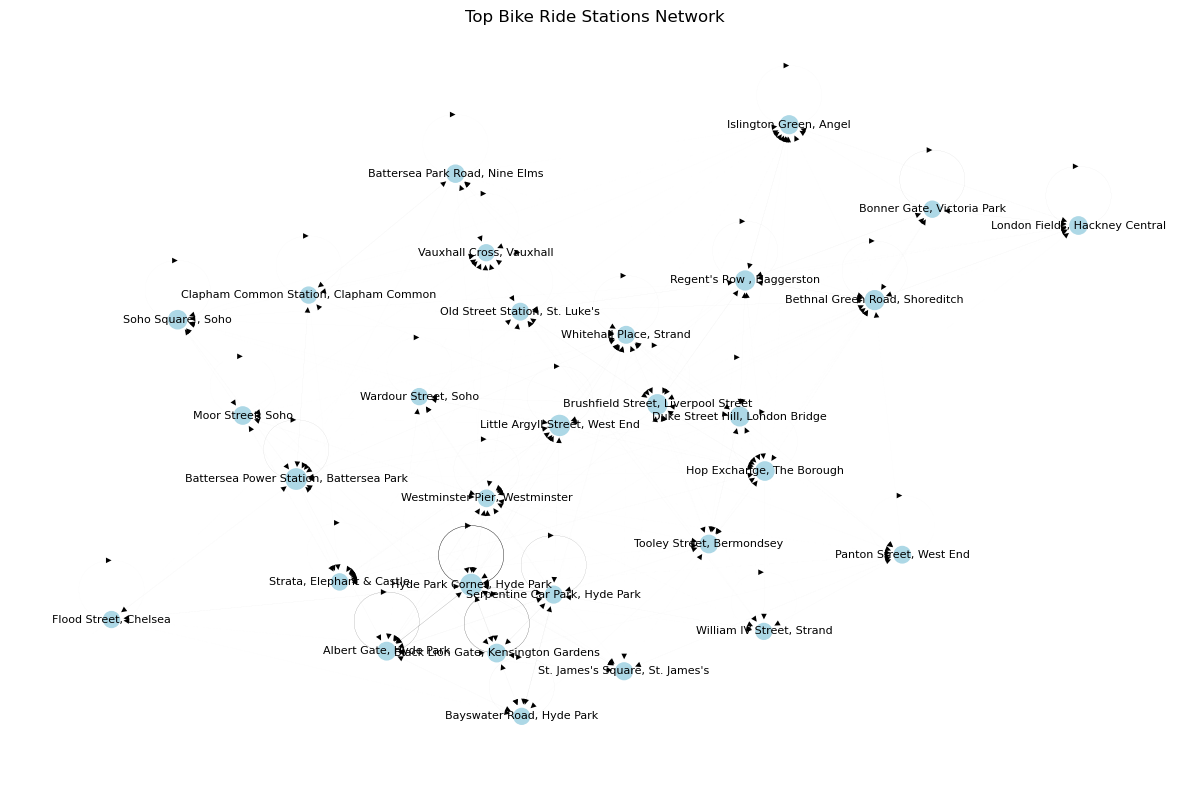


Weekend - Afternoon Peak Analysis:
Total Stations: 799
Total Routes: 22221

Station Removal Impact:

Random Removal:
remaining_stations: 640
remaining_routes: 14004
connectivity_reduction: 0.3697853381936006

High Centrality Removal:
remaining_stations: 640
remaining_routes: 8753
connectivity_reduction: 0.6060933351334323


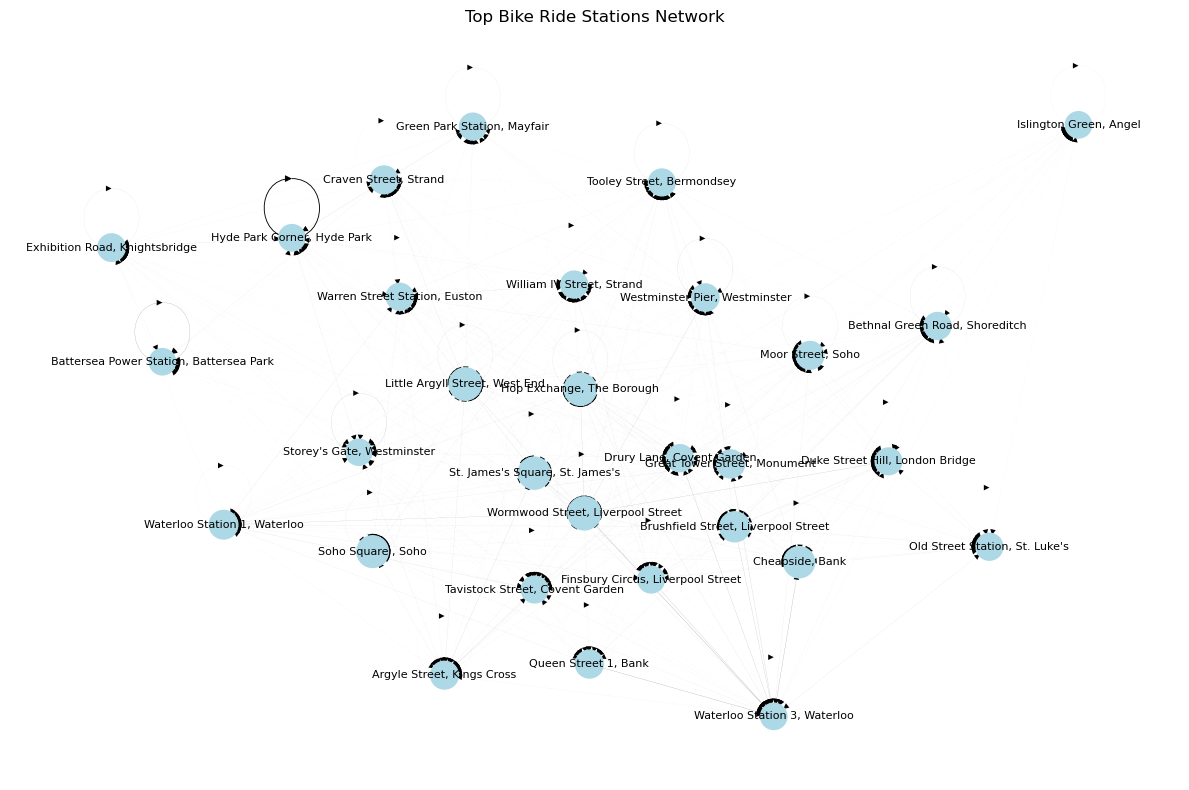


Weekday - Afternoon Peak Analysis:
Total Stations: 802
Total Routes: 64861

Station Removal Impact:

Random Removal:
remaining_stations: 642
remaining_routes: 42446
connectivity_reduction: 0.3455851744499776

High Centrality Removal:
remaining_stations: 642
remaining_routes: 26771
connectivity_reduction: 0.5872558239928463



Weekend - Evening Analysis:
Total Stations: 800
Total Routes: 17725

Station Removal Impact:

Random Removal:
remaining_stations: 640
remaining_routes: 11824
connectivity_reduction: 0.332919605077574

High Centrality Removal:
remaining_stations: 640
remaining_routes: 6936
connectivity_reduction: 0.608688293370945


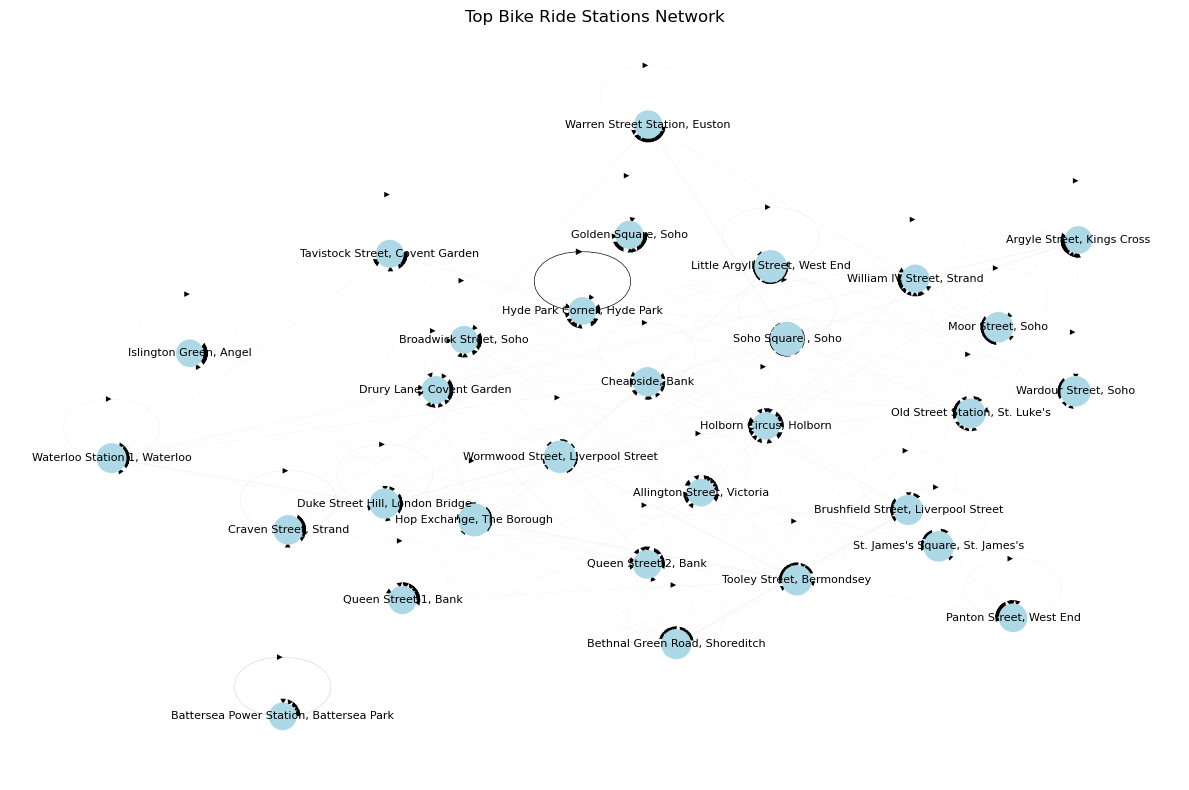


Weekday - Evening Analysis:
Total Stations: 801
Total Routes: 69131

Station Removal Impact:

Random Removal:
remaining_stations: 641
remaining_routes: 45368
connectivity_reduction: 0.34373869899176923

High Centrality Removal:
remaining_stations: 641
remaining_routes: 29894
connectivity_reduction: 0.5675746047359361


In [21]:
import seaborn as sns

def get_enhanced_time_segment(hour):
    hour = int(hour)
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Morning Peak'
    elif 12 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 18:
        return 'Afternoon Peak'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

def create_comprehensive_bike_ride_graph(df, time_segment=None, weekend_flag=None):

    df['datetime'] = pd.to_datetime(df['Start date'], format='%m/%d/%Y %H:%M', errors='coerce')
    
    df['hour'] = df['datetime'].dt.hour
    df['is_weekend'] = df['datetime'].dt.day_name().isin(['Saturday', 'Sunday'])
    
    df['time_segment'] = df['hour'].apply(get_enhanced_time_segment)
    
    filtered_df = df.copy()
    if time_segment is not None:
        filtered_df = filtered_df[filtered_df['time_segment'] == time_segment]
    
    if weekend_flag is not None:
        filtered_df = filtered_df[filtered_df['is_weekend'] == weekend_flag]
    
    filtered_df['Total duration'] = pd.to_numeric(filtered_df['Total duration'], errors='coerce')
    
    G = nx.DiGraph()
    
    ride_counts = filtered_df.groupby(['Start station', 'End station']).agg({
        'Bike number': 'count',
        'Total duration': ['mean', 'sum'] 
    }).reset_index()
    
    ride_counts.columns = ['Start station', 'End station', 'ride_count', 'avg_duration', 'total_duration']
    
    for _, row in ride_counts.iterrows():
        G.add_edge(
            row['Start station'], 
            row['End station'], 
            weight=row['ride_count'],
            avg_duration=row['avg_duration'],
            total_duration=row['total_duration']
        )
    visualize_graph(G)
    return G

def analyze_network_resilience(G):
    if len(G.nodes()) == 0:
        return None
    
    resilience_metrics = {
        'total_stations': len(G.nodes()),
        'total_routes': len(G.edges()),
        
        'in_degree_stats': {
            'mean': np.mean([d for n, d in G.in_degree()]),
            'median': np.median([d for n, d in G.in_degree()]),
            'max': max([d for n, d in G.in_degree()]),
        },
        'out_degree_stats': {
            'mean': np.mean([d for n, d in G.out_degree()]),
            'median': np.median([d for n, d in G.out_degree()]),
            'max': max([d for n, d in G.out_degree()]),
        },
        
        'centrality_metrics': {
            'degree_centrality': nx.degree_centrality(G),
            'betweenness_centrality': nx.betweenness_centrality(G),
        }
    }
    
    resilience_metrics['clustering_coefficient'] = nx.average_clustering(G)
    resilience_metrics['network_density'] = nx.density(G)
    
    return resilience_metrics

def simulate_station_removal(G, removal_percentage=20):

    all_stations = list(G.nodes())
    removal_count = int(len(all_stations) * (removal_percentage / 100))
    
    removal_strategies = {
        'Random Removal': np.random.choice(all_stations, removal_count, replace=False),
        'High Centrality Removal': sorted(
            nx.degree_centrality(G).items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:removal_count]
    }
    
    removal_results = {}
    
    for strategy_name, stations_to_remove in removal_strategies.items():
        G_modified = G.copy()
        
        stations_to_remove = [s[0] if isinstance(s, tuple) else s for s in stations_to_remove]
        G_modified.remove_nodes_from(stations_to_remove)
        
        removal_results[strategy_name] = {
            'remaining_stations': len(G_modified.nodes()),
            'remaining_routes': len(G_modified.edges()),
            'connectivity_reduction': 1 - (len(G_modified.edges()) / len(G.edges())),
        }
    
    return removal_results

def visualize_network_resilience(df):

    time_segments = ['Early Morning', 'Morning Peak', 'Midday', 'Afternoon Peak', 'Evening', 'Night']
    day_types = [True, False]
    
    resilience_data = {
        'total_stations': [],
        'total_routes': [],
        'labels': []
    }
    
    for time_segment in time_segments:
        for is_weekend in day_types:
            G = create_comprehensive_bike_ride_graph(df, time_segment, is_weekend)
            
            if len(G.edges()) == 0:
                continue
            
            resilience_metrics = analyze_network_resilience(G)
            
            if resilience_metrics:
                resilience_data['total_stations'].append(resilience_metrics['total_stations'])
                resilience_data['total_routes'].append(resilience_metrics['total_routes'])
                
                label = f"{'Weekend' if is_weekend else 'Weekday'}\n{time_segment}"
                resilience_data['labels'].append(label)
    
    

def enhanced_analyze_graphs(file_path):
    df = pd.read_csv(file_path)
    
    visualize_network_resilience(df)
    
    time_segments = ['Morning Peak', 'Afternoon Peak', 'Evening']
    day_types = [True, False]
    
    for time_segment in time_segments:
        for is_weekend in day_types:
            G = create_comprehensive_bike_ride_graph(df, time_segment, is_weekend)
            
            if len(G.edges()) == 0:
                continue
            
            resilience_metrics = analyze_network_resilience(G)
            
            day_type = 'Weekend' if is_weekend else 'Weekday'
            print(f"\n{day_type} - {time_segment} Analysis:")
            print(f"Total Stations: {resilience_metrics['total_stations']}")
            print(f"Total Routes: {resilience_metrics['total_routes']}")
            
            removal_impact = simulate_station_removal(G)
            print("\nStation Removal Impact:")
            for strategy, results in removal_impact.items():
                print(f"\n{strategy}:")
                for metric, value in results.items():
                    print(f"{metric}: {value}")
    
    return G

analyze_graphs = enhanced_analyze_graphs('LondonBikeJourneyAug2023.csv')

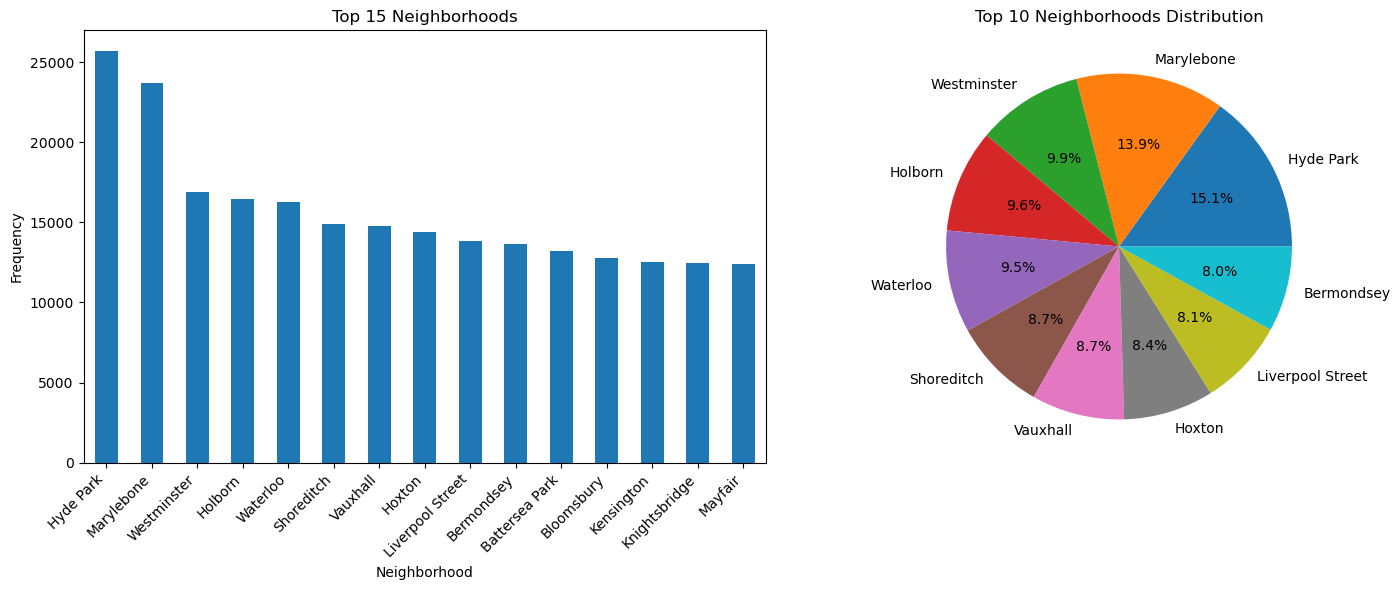


--- Neighborhood Analysis ---
Total Unique Neighborhoods: 125

Top 10 Most Frequent Neighborhoods:
Hyde Park: 25693
Marylebone: 23683
Westminster: 16876
Holborn: 16427
Waterloo: 16275
Shoreditch: 14894
Vauxhall: 14777
Hoxton: 14364
Liverpool Street: 13817
Bermondsey: 13619


In [19]:
import re

def extract_neighborhood(location_string):
    if not isinstance(location_string, str):
        return None
    
    parts = location_string.split(',')
    if len(parts) > 1:
        neighborhood = parts[1].strip()
        
        neighborhood = re.sub(r'\s+', ' ', neighborhood) 
        neighborhood = neighborhood.title()  
        
        return neighborhood
    
    neighborhood_patterns = [
        r'\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)?)\b',  
    ]
    
    for pattern in neighborhood_patterns:
        match = re.search(pattern, location_string)
        if match:
            return match.group(1).title()
    
    return None

def comprehensive_neighborhood_analysis(file_path, column_name):
 
    df = pd.read_csv(file_path)
    
    df['Neighborhood'] = df[column_name].apply(extract_neighborhood)
    
    neighborhood_analysis = {
        'total_neighborhoods': 0,
        'unique_neighborhoods': [],
        'neighborhood_frequency': {},
        'geographical_distribution': {}
    }
    
    unique_neighborhoods = df['Neighborhood'].dropna().unique()
    neighborhood_analysis['total_neighborhoods'] = len(unique_neighborhoods)
    neighborhood_analysis['unique_neighborhoods'] = sorted(unique_neighborhoods)
    
    neighborhood_counts = df['Neighborhood'].value_counts()
    neighborhood_analysis['neighborhood_frequency'] = neighborhood_counts.to_dict()
    
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    neighborhood_counts.head(15).plot(kind='bar')
    plt.title('Top 15 Neighborhoods')
    plt.xlabel('Neighborhood')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(1, 2, 2)
    top_10_neighborhoods = neighborhood_counts.head(10)
    plt.pie(top_10_neighborhoods, labels=top_10_neighborhoods.index, autopct='%1.1f%%')
    plt.title('Top 10 Neighborhoods Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print("\n--- Neighborhood Analysis ---")
    print(f"Total Unique Neighborhoods: {neighborhood_analysis['total_neighborhoods']}")
    print("\nTop 10 Most Frequent Neighborhoods:")
    for neighborhood, count in list(neighborhood_analysis['neighborhood_frequency'].items())[:10]:
        print(f"{neighborhood}: {count}")
    
    return df, neighborhood_analysis
_, analysis = comprehensive_neighborhood_analysis('LondonBikeJourneyAug2023.csv', 'Start station')

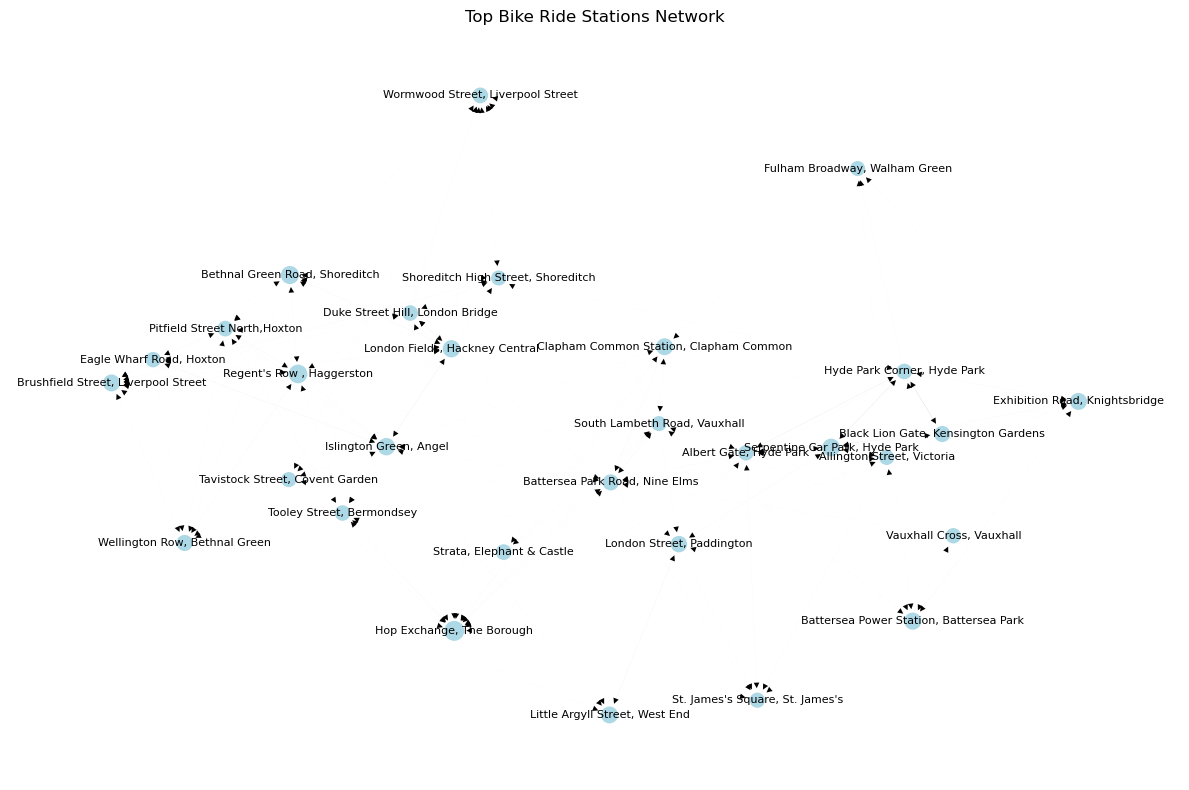


Weekend - Morning Peak Analysis:
Total Stations: 799
Total Routes: 17675

Station Removal Impact:

Random Removal:
remaining_stations: 640
remaining_routes: 11402
connectivity_reduction: 0.3549080622347949

High Centrality Removal:
remaining_stations: 640
remaining_routes: 7032
connectivity_reduction: 0.6021499292786421


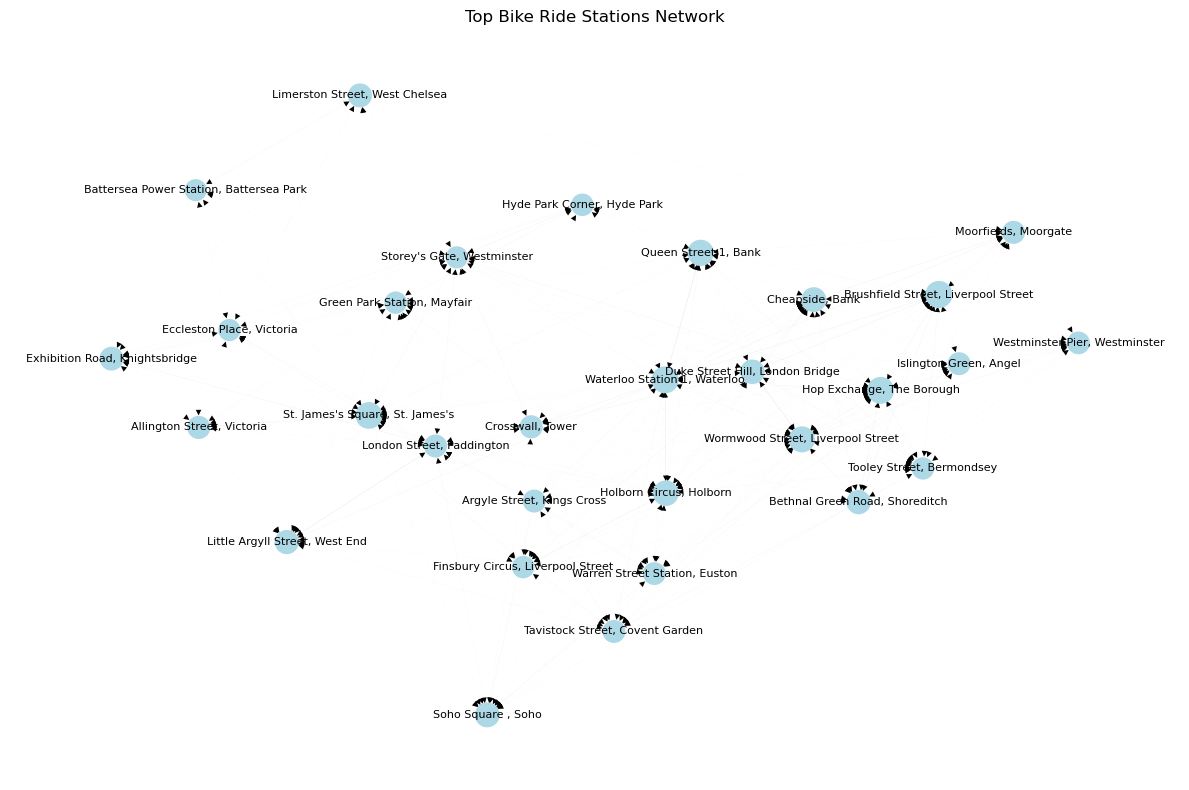


Weekday - Morning Peak Analysis:
Total Stations: 801
Total Routes: 41295

Station Removal Impact:

Random Removal:
remaining_stations: 641
remaining_routes: 26626
connectivity_reduction: 0.355224603462889

High Centrality Removal:
remaining_stations: 641
remaining_routes: 17046
connectivity_reduction: 0.5872139484199055


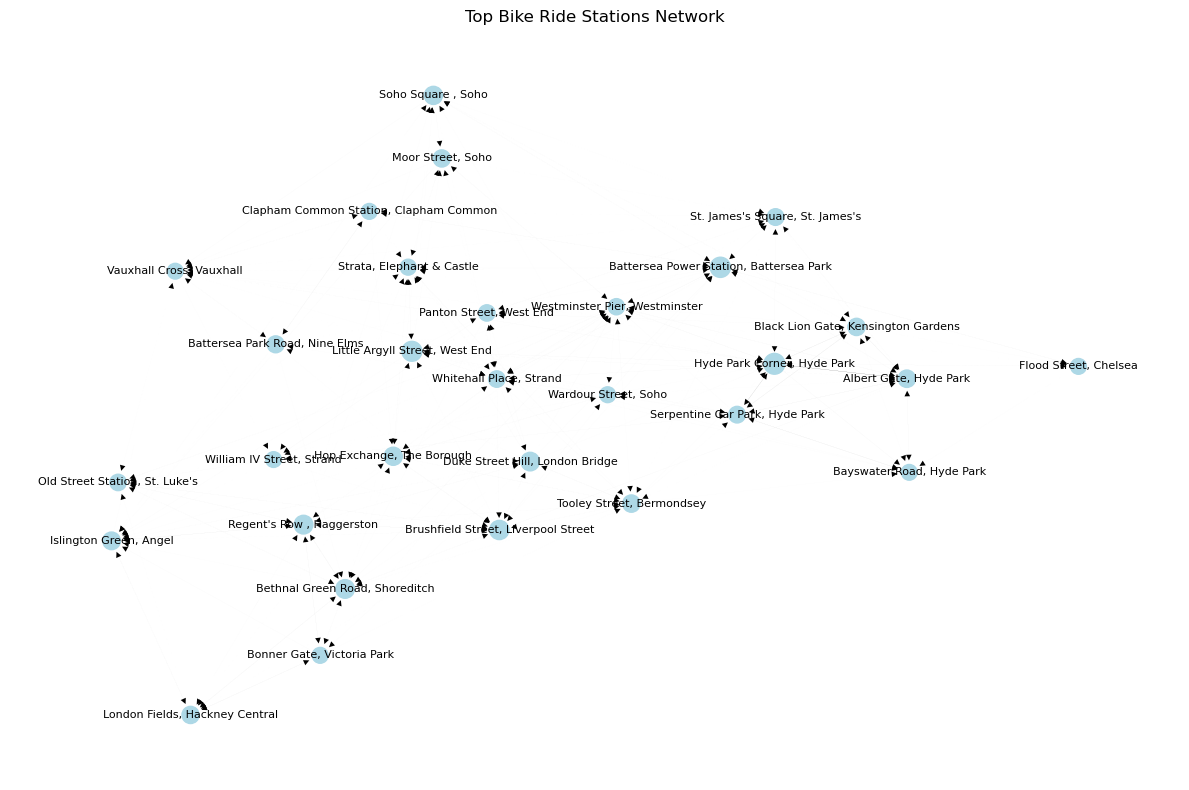


Weekend - Afternoon Peak Analysis:
Total Stations: 799
Total Routes: 21692

Station Removal Impact:

Random Removal:
remaining_stations: 640
remaining_routes: 14251
connectivity_reduction: 0.343029688364374

High Centrality Removal:
remaining_stations: 640
remaining_routes: 8366
connectivity_reduction: 0.6143278628065647


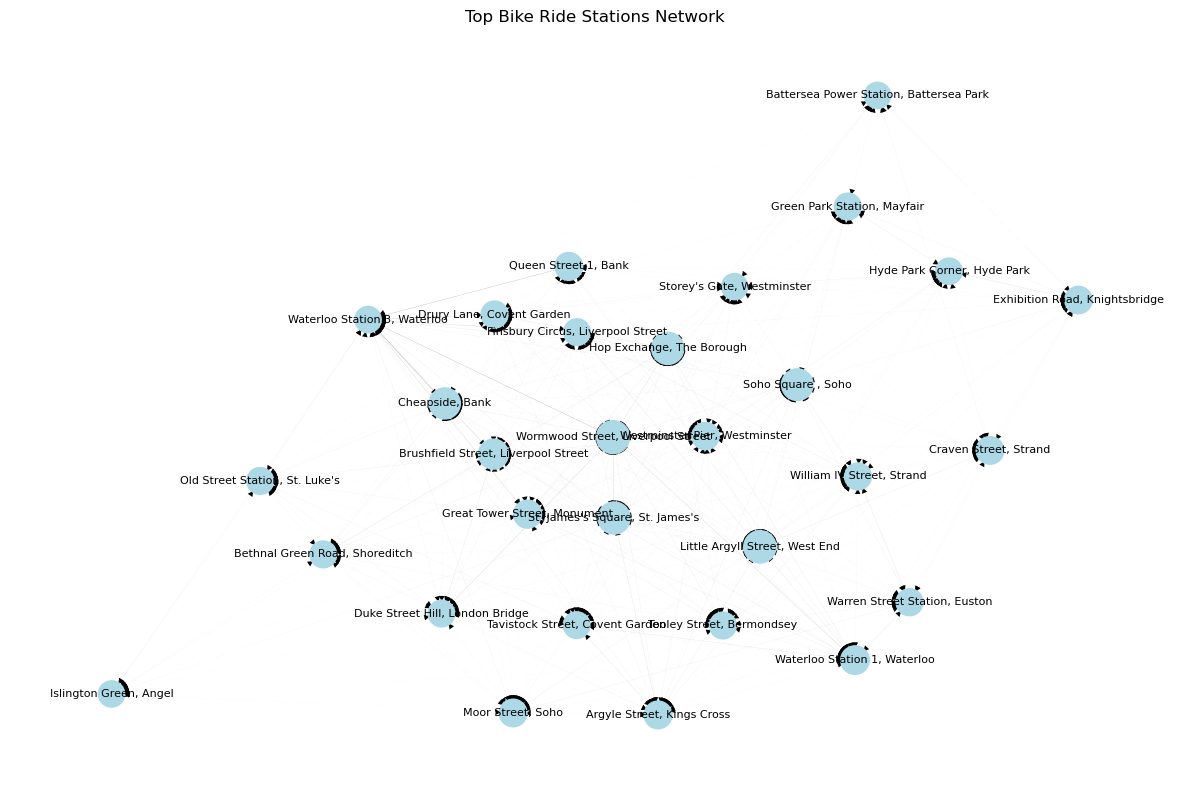


Weekday - Afternoon Peak Analysis:
Total Stations: 802
Total Routes: 64135

Station Removal Impact:

Random Removal:
remaining_stations: 642
remaining_routes: 41113
connectivity_reduction: 0.3589615654478834

High Centrality Removal:
remaining_stations: 642
remaining_routes: 26193
connectivity_reduction: 0.5915958524986357


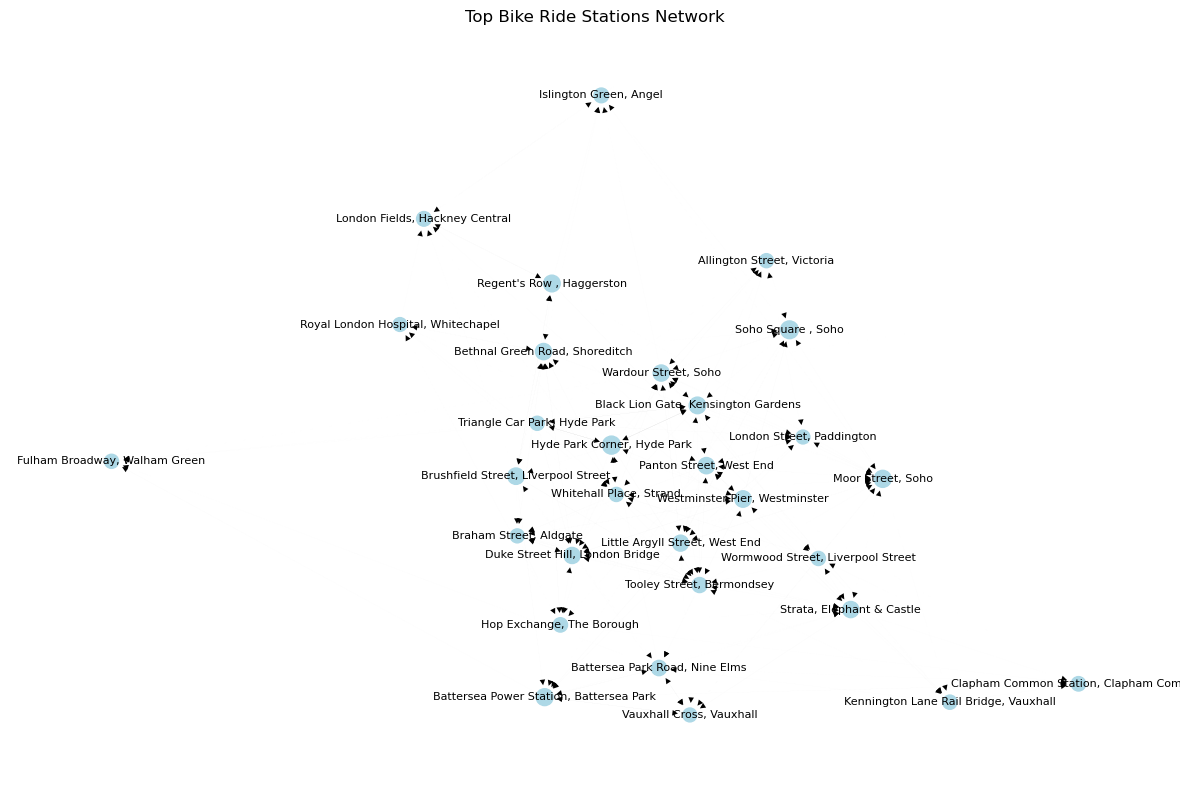


Weekend - Evening Analysis:
Total Stations: 800
Total Routes: 17197

Station Removal Impact:

Random Removal:
remaining_stations: 640
remaining_routes: 10885
connectivity_reduction: 0.36704076292376575

High Centrality Removal:
remaining_stations: 640
remaining_routes: 6537
connectivity_reduction: 0.6198755596906438


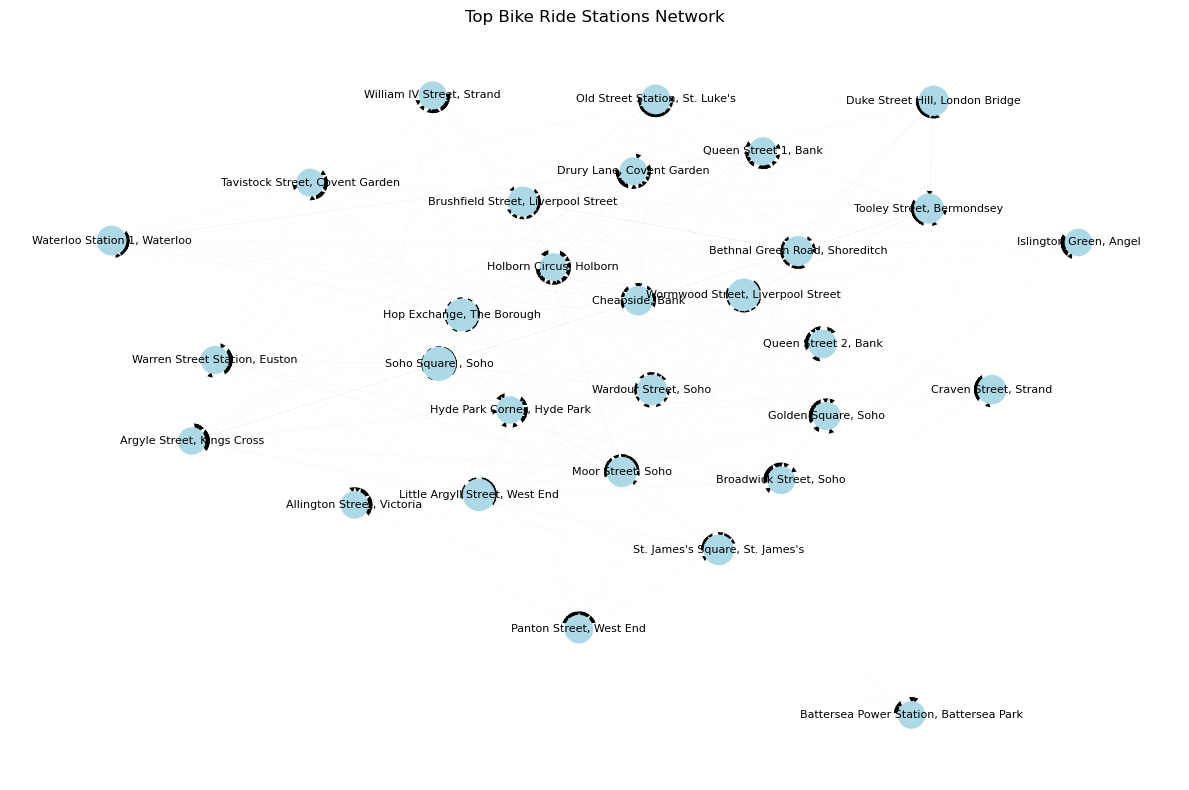


Weekday - Evening Analysis:
Total Stations: 801
Total Routes: 68385

Station Removal Impact:

Random Removal:
remaining_stations: 641
remaining_routes: 44727
connectivity_reduction: 0.345953059881553

High Centrality Removal:
remaining_stations: 641
remaining_routes: 29307
connectivity_reduction: 0.5714411055055933


In [17]:
def get_enhanced_time_segment(hour):
    hour = int(hour)
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Morning Peak'
    elif 12 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 18:
        return 'Afternoon Peak'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

def create_comprehensive_bike_ride_graph(df, time_segment=None, weekend_flag=None):
    df['datetime'] = pd.to_datetime(df['Start date'], format='%m/%d/%Y %H:%M', errors='coerce')
    
    df['hour'] = df['datetime'].dt.hour
    df['is_weekend'] = df['datetime'].dt.day_name().isin(['Saturday', 'Sunday'])
    
    df['time_segment'] = df['hour'].apply(get_enhanced_time_segment)
    
    filtered_df = df.copy()
    if time_segment is not None:
        filtered_df = filtered_df[filtered_df['time_segment'] == time_segment]
    
    if weekend_flag is not None:
        filtered_df = filtered_df[filtered_df['is_weekend'] == weekend_flag]
    
    filtered_df['Total duration'] = pd.to_numeric(filtered_df['Total duration'], errors='coerce')
    
    filtered_df = filtered_df[filtered_df['Start station'] != filtered_df['End station']]
    
    G = nx.DiGraph()
    
    ride_counts = filtered_df.groupby(['Start station', 'End station']).agg({
        'Bike number': 'count',
        'Total duration': ['mean', 'sum'] 
    }).reset_index()
    
    ride_counts.columns = ['Start station', 'End station', 'ride_count', 'avg_duration', 'total_duration']
    
    for _, row in ride_counts.iterrows():
        G.add_edge(
            row['Start station'], 
            row['End station'], 
            weight=row['ride_count'],
            avg_duration=row['avg_duration'],
            total_duration=row['total_duration']
        )
    visualize_graph(G)
    return G

def analyze_network_resilience(G):
    if len(G.nodes()) == 0:
        return None
    
    resilience_metrics = {
        'total_stations': len(G.nodes()),
        'total_routes': len(G.edges()),
        
        'in_degree_stats': {
            'mean': np.mean([d for n, d in G.in_degree()]),
            'median': np.median([d for n, d in G.in_degree()]),
            'max': max([d for n, d in G.in_degree()]),
        },
        'out_degree_stats': {
            'mean': np.mean([d for n, d in G.out_degree()]),
            'median': np.median([d for n, d in G.out_degree()]),
            'max': max([d for n, d in G.out_degree()]),
        },
        
        'centrality_metrics': {
            'degree_centrality': nx.degree_centrality(G),
            'betweenness_centrality': nx.betweenness_centrality(G),
        }
    }
    
    resilience_metrics['clustering_coefficient'] = nx.average_clustering(G)
    resilience_metrics['network_density'] = nx.density(G)
    
    return resilience_metrics

def simulate_station_removal(G, removal_percentage=20):
    all_stations = list(G.nodes())
    removal_count = int(len(all_stations) * (removal_percentage / 100))
    
    removal_strategies = {
        'Random Removal': np.random.choice(all_stations, removal_count, replace=False),
        'High Centrality Removal': sorted(
            nx.degree_centrality(G).items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:removal_count]
    }
    
    removal_results = {}
    
    for strategy_name, stations_to_remove in removal_strategies.items():
        G_modified = G.copy()
        
        stations_to_remove = [s[0] if isinstance(s, tuple) else s for s in stations_to_remove]
        G_modified.remove_nodes_from(stations_to_remove)
        
        removal_results[strategy_name] = {
            'remaining_stations': len(G_modified.nodes()),
            'remaining_routes': len(G_modified.edges()),
            'connectivity_reduction': 1 - (len(G_modified.edges()) / len(G.edges())),
        }
    
    return removal_results

def enhanced_analyze_graphs(file_path):
    df = pd.read_csv(file_path)
    
    time_segments = ['Morning Peak', 'Afternoon Peak', 'Evening']
    day_types = [True, False]
    
    for time_segment in time_segments:
        for is_weekend in day_types:
            G = create_comprehensive_bike_ride_graph(df, time_segment, is_weekend)
            
            if len(G.edges()) == 0:
                continue
            
            resilience_metrics = analyze_network_resilience(G)
            
            day_type = 'Weekend' if is_weekend else 'Weekday'
            print(f"\n{day_type} - {time_segment} Analysis:")
            print(f"Total Stations: {resilience_metrics['total_stations']}")
            print(f"Total Routes: {resilience_metrics['total_routes']}")
            
            removal_impact = simulate_station_removal(G)
            print("\nStation Removal Impact:")
            for strategy, results in removal_impact.items():
                print(f"\n{strategy}:")
                for metric, value in results.items():
                    print(f"{metric}: {value}")
    
    return G

# Main function call
analyze_graphs = enhanced_analyze_graphs('LondonBikeJourneyAug2023.csv')


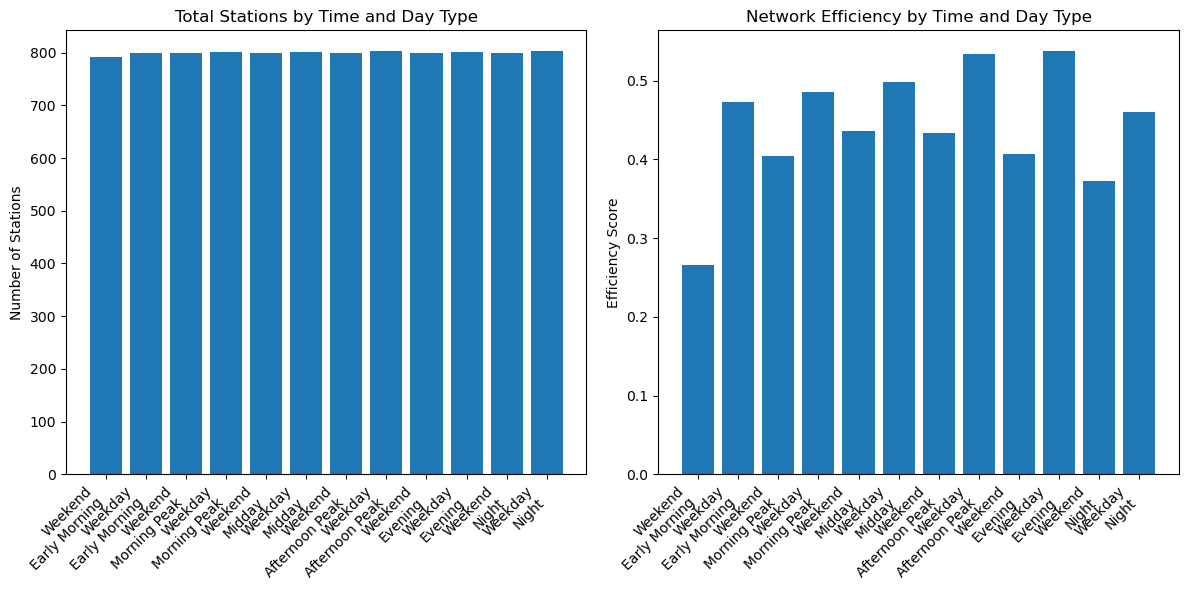

In [31]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_enhanced_time_segment(hour):
    """
    Categorize hours into time segments
    
    :param hour: Hour of the day
    :return: Time segment label
    """
    hour = int(hour)
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Morning Peak'
    elif 12 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 18:
        return 'Afternoon Peak'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

def create_comprehensive_graph(df, time_segment=None, weekend_flag=None):
    """
    Create a comprehensive directed graph from bike journey data
    
    :param df: Input DataFrame
    :param time_segment: Optional time segment to filter
    :param weekend_flag: Optional weekend flag to filter
    :return: Networkx DiGraph
    """
    # Preprocess data
    df['datetime'] = pd.to_datetime(df['Start date'], format='%m/%d/%Y %H:%M', errors='coerce')
    df['hour'] = df['datetime'].dt.hour
    df['is_weekend'] = df['datetime'].dt.day_name().isin(['Saturday', 'Sunday'])
    df['time_segment'] = df['hour'].apply(get_enhanced_time_segment)
    
    # Apply filters
    filtered_df = df.copy()
    if time_segment is not None:
        filtered_df = filtered_df[filtered_df['time_segment'] == time_segment]
    
    if weekend_flag is not None:
        filtered_df = filtered_df[filtered_df['is_weekend'] == weekend_flag]
    
    # Create graph
    filtered_df['Total duration'] = pd.to_numeric(filtered_df['Total duration'], errors='coerce')
    
    G = nx.DiGraph()
    
    # Aggregate ride information
    ride_counts = filtered_df.groupby(['Start station', 'End station']).agg({
        'Bike number': 'count',
        'Total duration': ['mean', 'sum'] 
    }).reset_index()
    
    ride_counts.columns = ['Start station', 'End station', 'ride_count', 'avg_duration', 'total_duration']
    
    for _, row in ride_counts.iterrows():
        G.add_edge(
            row['Start station'], 
            row['End station'], 
            weight=row['ride_count'],
            avg_duration=row['avg_duration'],
            total_duration=row['total_duration']
        )
    
    return G

def calculate_network_efficiency(G):
    """
    Calculate network efficiency
    
    :param G: Networkx graph
    :return: Network efficiency score
    """
    if not nx.is_connected(G.to_undirected()):
        return 0
    
    n = len(G.nodes())
    total_inv_path_length = 0
    
    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 != node2:
                try:
                    path_length = nx.shortest_path_length(G, node1, node2)
                    total_inv_path_length += 1 / path_length
                except nx.NetworkXNoPath:
                    continue
    
    return total_inv_path_length / (n * (n - 1))

def comprehensive_network_resilience(G):
    """
    Comprehensive network resilience analysis
    
    :param G: Networkx graph
    :return: Dictionary of network resilience metrics
    """
    if len(G.nodes()) == 0:
        return None
    
    # Basic network metrics
    resilience_metrics = {
        'total_stations': len(G.nodes()),
        'total_routes': len(G.edges()),
        
        'in_degree_stats': {
            'mean': np.mean([d for n, d in G.in_degree()]),
            'median': np.median([d for n, d in G.in_degree()]),
            'max': max([d for n, d in G.in_degree()]),
        },
        'out_degree_stats': {
            'mean': np.mean([d for n, d in G.out_degree()]),
            'median': np.median([d for n, d in G.out_degree()]),
            'max': max([d for n, d in G.out_degree()]),
        }
        
        
    }
    
    # Additional network characteristics
    try:
        resilience_metrics['connected_components'] = nx.number_connected_components(G.to_undirected())
        resilience_metrics['largest_component_size'] = len(max(nx.connected_components(G.to_undirected()), key=len))
        
        resilience_metrics['network_diameter'] = nx.diameter(G.to_undirected())
        resilience_metrics['average_path_length'] = nx.average_shortest_path_length(G.to_undirected())
    except nx.NetworkXError:
        # Handle cases where the graph is not connected
        resilience_metrics['network_diameter'] = float('inf')
        resilience_metrics['average_path_length'] = float('inf')
    
    # Additional network metrics
    resilience_metrics['clustering_coefficient'] = nx.average_clustering(G)
    resilience_metrics['network_density'] = nx.density(G)
    resilience_metrics['network_efficiency'] = calculate_network_efficiency(G)
    
    return resilience_metrics

def simulate_advanced_station_removal(G, removal_percentage=20):
    """
    Advanced station removal simulation with multiple strategies
    
    :param G: Networkx graph
    :param removal_percentage: Percentage of stations to remove
    :return: Dictionary of removal strategy results
    """
    all_stations = list(G.nodes())
    removal_count = int(len(all_stations) * (removal_percentage / 100))
    
    # Define removal strategies
    removal_strategies = {
        'Random Removal': np.random.choice(all_stations, removal_count, replace=False),
        'High Centrality Removal': [
            station for station, _ in sorted(
                nx.degree_centrality(G).items(), 
                key=lambda x: x[1], 
                reverse=True
            )[:removal_count]
        ],
        'Betweenness Centrality Removal': [
            station for station, _ in sorted(
                nx.betweenness_centrality(G).items(), 
                key=lambda x: x[1], 
                reverse=True
            )[:removal_count]
        ],
        'Low Degree Removal': [
            station for station, _ in sorted(
                G.degree(), 
                key=lambda x: x[1]
            )[:removal_count]
        ]
    }
    
    removal_results = {}
    
    for strategy_name, stations_to_remove in removal_strategies.items():
        # Create a copy of the graph
        G_modified = G.copy()
        
        # Remove selected stations
        G_modified.remove_nodes_from(stations_to_remove)
        
        # Calculate resilience metrics
        removal_results[strategy_name] = {
            'removed_stations': stations_to_remove,
            'remaining_stations': len(G_modified.nodes()),
            'remaining_routes': len(G_modified.edges()),
            'connectivity_reduction': 1 - (len(G_modified.edges()) / len(G.edges())),
            'network_efficiency_reduction': (
                calculate_network_efficiency(G_modified) / 
                calculate_network_efficiency(G) if 
                calculate_network_efficiency(G) > 0 else 0
            )
        }
    
    return removal_results

def visualize_network_resilience(df):
    """
    Visualize network resilience across different conditions
    
    :param df: Input DataFrame
    :return: Matplotlib figure
    """
    time_segments = ['Early Morning', 'Morning Peak', 'Midday', 'Afternoon Peak', 'Evening', 'Night']
    day_types = [True, False]
    
    resilience_data = {
        'total_stations': [],
        'total_routes': [],
        'network_efficiency': [],
        'labels': []
    }
    
    for time_segment in time_segments:
        for is_weekend in day_types:
            G = create_comprehensive_graph(df, time_segment, is_weekend)
            
            if len(G.edges()) == 0:
                continue
            
            resilience_metrics = comprehensive_network_resilience(G)
            
            if resilience_metrics:
                resilience_data['total_stations'].append(resilience_metrics['total_stations'])
                resilience_data['total_routes'].append(resilience_metrics['total_routes'])
                resilience_data['network_efficiency'].append(resilience_metrics['network_efficiency'])
                
                label = f"{'Weekend' if is_weekend else 'Weekday'}\n{time_segment}"
                resilience_data['labels'].append(label)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Subplot for total stations and routes
    plt.subplot(1, 2, 1)
    plt.bar(resilience_data['labels'], resilience_data['total_stations'], label='Total Stations')
    plt.title('Total Stations by Time and Day Type')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Stations')
    
    # Subplot for network efficiency
    plt.subplot(1, 2, 2)
    plt.bar(resilience_data['labels'], resilience_data['network_efficiency'], label='Network Efficiency')
    plt.title('Network Efficiency by Time and Day Type')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Efficiency Score')
    
    plt.tight_layout()
    return plt

def run_comprehensive_network_analysis(file_path):
    """
    Perform comprehensive network resilience analysis
    
    :param file_path: Path to the input CSV file
    :return: Dictionary of analysis results
    """
    # Read the data
    df = pd.read_csv(file_path)
    
    # Define analysis parameters
    time_segments = ['Early Morning', 'Morning Peak', 'Midday', 'Afternoon Peak', 'Evening', 'Night']
    day_types = [True, False]
    
    # Store analysis results
    analysis_results = {}
    
    for time_segment in time_segments:
        for is_weekend in day_types:
            # Create graph
            G = create_comprehensive_graph(df, time_segment, is_weekend)
            
            if len(G.edges()) == 0:
                continue
            
            day_type = 'Weekend' if is_weekend else 'Weekday'
            key = f"{day_type} - {time_segment}"
            
            # Analyze network resilience
            analysis_results[key] = {
                'resilience_metrics': comprehensive_network_resilience(G),
                'removal_impact': simulate_advanced_station_removal(G)
            }
    
    # Visualize results
    plt = visualize_network_resilience(df)
    plt.show()
    
    return analysis_results

# Example usage
results = run_comprehensive_network_analysis('LondonBikeJourneyAug2023.csv')

In [ ]:
results

{'Weekend - Early Morning': {'resilience_metrics': {'total_stations': 792,
   'total_routes': 5864,
   'in_degree_stats': {'mean': 7.404040404040404, 'median': 6.0, 'max': 47},
   'out_degree_stats': {'mean': 7.404040404040404, 'median': 7.0, 'max': 31},
   'connected_components': 1,
   'largest_component_size': 792,
   'network_diameter': 6,
   'average_path_length': 2.949590723927007,
   'clustering_coefficient': 0.03811584939352471,
   'network_density': 0.009360354493097855,
   'network_efficiency': 0.26609569016100126},
  'removal_impact': {'Random Removal': {'removed_stations': array(['Bedford Way, Bloomsbury', 'Mostyn Grove, Bow',
           'Albert Square, Stockwell', 'Stanley Grove, Battersea',
           'Aberfeldy Street, Poplar', 'Argyle Street, Kings Cross',
           "London Zoo Car Park, The Regent's Park",
           'Broadley Terrace, Marylebone', 'Malmesbury Road, Bow',
           'Colet Gardens, Hammersmith', 'Doric Way , Somers Town',
           'King Edward Street